In [1]:
import numpy as np
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Load the dataset
import pickle

import numpy as np
import random
import warnings

import scipy.sparse as sp
 
import pickle
from scipy.sparse import eye
from scipy.sparse.linalg import inv

import scipy.sparse as sp
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse import triu, tril, csr_matrix, coo_matrix
 
import time
from RelaxRegularizeAPPR import *

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from scipy.sparse import random as sparse_random

from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import inv
from numpy.linalg import pinv

from data_loader import *

from sparsify import *
import multiprocessing

import networkx as nx
from networkx.algorithms import community

/home/yifan/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yifan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

dataset_list = ['political-blog', 'citeseer', 'cora', 'mnist-tr-nei10', 'pubmed', 'blogcatalog']

dataset_list = ['political-blog','citeseer','cora', 'mnist-tr-nei10', 'pubmed', 'blogcatalog', 'ogbn-arxiv', 'youtube']

dataset_list = ['political-blog','citeseer','cora', 'mnist-tr-nei10', 'pubmed', 'blogcatalog']#, 'ogbn-arxiv', 'youtube']
dataset_list = ['political-blog','blogcatalog','citeseer','cora',  'mnist-tr-nei10', 'pubmed']#, 'ogbn-arxiv', 'youtube']
dataset_list = ['political-blog','citeseer','cora', 'mnist-tr-nei10', 'pubmed', 'blogcatalog']


In [3]:

sparse_list = ['orig','influencer','uniform','resistive']
sparse_list_label = ['O','I','U','R']

splevel_list = [10,5,2,1,.5,.25]
cutvals = np.zeros((len(dataset_list), len(sparse_list),len(splevel_list)))
num_neighbors = np.zeros((len(dataset_list),len(sparse_list), len(splevel_list)))
inverse_cut = np.zeros((len(dataset_list),len(sparse_list), len(splevel_list)))
                    
beta = 1
trial = 0
for d,dataset in enumerate(dataset_list[:-2]):

    adj_matrix_orig, labels = load_graph_data(dataset)
    if not isinstance(adj_matrix_orig, csr_matrix):
        adj_matrix_orig = csr_matrix(adj_matrix_orig)        
    n = len(labels)
    num_classes = max(labels)+1
    Delta = num_classes

    mat = {}
    for sp,sparselevel in enumerate(splevel_list):
        for s,sparse in enumerate(sparse_list):
        
            
            if not (sparse == 'orig'):
                if dataset == 'blogcatalog': continue

                if sparse == 'influencer':
                    node_degrees = adj_matrix_orig.getnnz(axis=1)
                    c = int(np.round(np.median(node_degrees)*sparselevel))
                    if c == 0: continue
                    if d == 0: print(c)
                    
                    spmat_string = '%s_sparse%s_c%d_spmat_trial%d' % (dataset,sparse,c,trial)
                else:
                    if c == 0: continue
                    if 'influencer' not in mat.keys():
                        print('influencer for %s not available yet \n', dataset)
                        continue
                    p = np.round(100*mat['influencer'].nnz / mat['orig'].nnz)/100
                    spmat_string = '%s_sparse%s_p%f_spmat_trial%d' % (dataset,sparse,p,trial)
                    if d == 0: print(p)
                try:
                    adj_matrix = pickle.load(open('offline_sparsify/%s.pkl' % spmat_string,'rb'))
                except:
                    print('file not available yet: %s\n' % spmat_string)
                    continue
            else:
                adj_matrix = adj_matrix_orig
            mat[sparse] = adj_matrix     




            degrees = np.array(adj_matrix.sum(axis=1)).flatten()

            Theta,nTheta, Y_onehot =  prepare_small_problems(adj_matrix,labels)
            Y_onehot_0 = Y_onehot + 0.

            if beta == 0.:
                T = Theta
                b = 1.

            else:
                b = beta 
                T= beta * nTheta + (1. - beta) * eye(n)

            sigma = 0
            for i in range(Y_onehot.shape[1]):
                for j in range(Y_onehot.shape[1]):
                    if i <= j: continue
                    sigma += ( Y_onehot[:,i].T @ (adj_matrix @ Y_onehot[:,j])).diagonal().sum()
            print(dataset, sparse, sparselevel, sigma)
            cutvals[d,s,sp] = sigma

            num_neighbors[d,s,sp] = adj_matrix.nnz
            
            """
            # Create a graph from adjacency matrix
            G = nx.from_numpy_array(adj_matrix)

            # Convert one-hot encoded community labels to list of sets
            Y_onehot = Y_onehot.toarray()
            communities = [set(np.where(Y_onehot[:, i] >0 )[0]) for i in range(Y_onehot.shape[1])]

            # Calculate modularity
            mod = community.modularity(G, communities)
            modularity[d,s,sp] = mod
            """

            sigma = ( Y_onehot.T @ (adj_matrix @ Y_onehot)).diagonal().sum()
            inverse_cut[d,s,sp] = sigma

print(inverse_cut[0,:,:])
print(cutvals[0,:,:])

political-blog orig 10 1575.0
130
political-blog influencer 10 7944.081678691309
0.9
political-blog uniform 10 1402.0
0.9
political-blog resistive 10 1578.888888888884
political-blog orig 5 1575.0
65
political-blog influencer 5 8251.414645357612
0.67
political-blog uniform 5 1034.0
0.67
political-blog resistive 5 1598.5074626865714
political-blog orig 2 1575.0
26
political-blog influencer 2 1610.2709375279965
0.32
political-blog uniform 2 508.0
0.32
political-blog resistive 2 1646.875
political-blog orig 1 1575.0
13
political-blog influencer 1 920.1948256322048
0.17
political-blog uniform 1 289.0
0.17
political-blog resistive 1 1770.5882352941244
political-blog orig 0.5 1575.0
6
political-blog influencer 0.5 377.0879349103982
0.08
political-blog uniform 0.5 121.01447801375997
0.08
political-blog resistive 0.5 1950.0
political-blog orig 0.25 1575.0
3
political-blog influencer 0.25 453.89637166214595
0.07
political-blog uniform 0.25 110.38297616903769
0.07
political-blog resistive 0.25 1

[ 2444  9039 33431]
[4218 5563 7336]
[ 4968  7097 10138]
[ 12000  48271 194178]


/tmp/ipykernel_676/863887963.py:20: RuntimeWarning: invalid value encountered in divide
  term = cutvals[i,j,:]/inverse_cut[i,j,:]


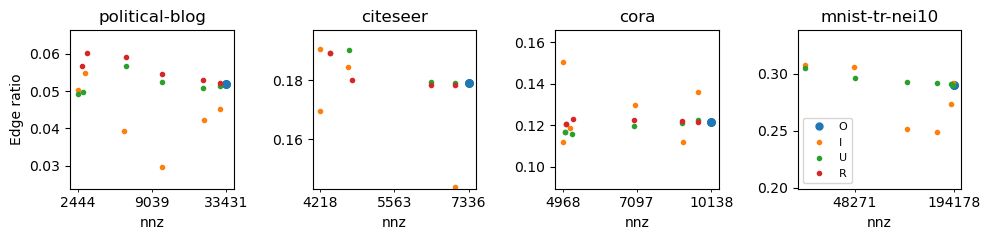

In [4]:


num_datasets = len(dataset_list)

fig, axes = plt.subplots(1, 4, figsize=(10,  2.5))
axes = axes.flatten()  # Flatten to iterate easily

indices = np.arange(len(sparse_list))

for i, dataset in enumerate(dataset_list[:-2]):
    ax = axes[i]  # Select the correct subplot

    max_term = 0
    min_term = n
    minxterm = n
    maxxterm = 0
    for j in range(len(sparse_list)):
        if j == 0:
            markersize = 5
        else:
            markersize = 3
        term = cutvals[i,j,:]/inverse_cut[i,j,:]
        idx = np.logical_not(np.isnan(term))
        
        ax.plot(num_neighbors[i,j,idx], term[idx],label='%s' % sparse_list_label[j],markersize=markersize,marker='o',linewidth=0,color=colors[j])
        max_term = max(max_term,np.max(term))
        min_term = min(min_term,np.min(term))
        if np.sum(idx) > 0:
            maxxterm = max(maxxterm,np.max(num_neighbors[i,j,idx]))
            minxterm = min(minxterm,np.min(num_neighbors[i,j,idx]))
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim([min_term*.8,max_term*1.1])
    ax.set_xlabel('nnz')
    if i in [0]: ax.set_ylabel('Edge ratio')
    ax.set_title(f'{dataset}')
    # Customizing x-axis ticks for better readability
    #ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=3))
    
    ax.xaxis.set_major_locator(plt.NullLocator())
    minor_tick_positions = np.round(np.logspace(np.log10(minxterm),np.log10(maxxterm),3)).astype(int)
    print(minor_tick_positions)
    ax.xaxis.set_minor_locator(plt.FixedLocator(minor_tick_positions))

    ax.tick_params(axis='x', which='minor')  # Rotate x-axis labels to prevent overlap
    ax.set_xticklabels(['%d'% m for m in minor_tick_positions], minor=True)

ax.legend(fontsize=8)


plt.tight_layout()
plt.savefig('cutvals_offline.png')


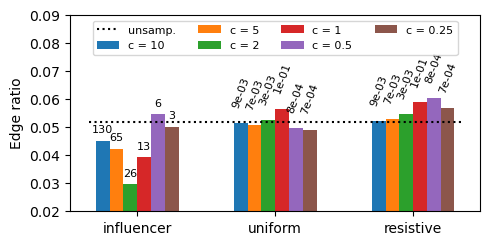

In [30]:
from c_p_lookup import *
 

num_datasets = len(dataset_list)

indices = np.arange(len(sparse_list))
fig, ax = plt.subplots(figsize=(5, 2.5))

i = 0

barwidth = .1

for j,sparselevel in enumerate(splevel_list): 
    term = cutvals[i,1:,j]/inverse_cut[i,1:,j] 
    positions = np.arange(len(term)) + j * barwidth 
    c = c_lookup['political-blog']['influencer',sparselevel]
    p = c_lookup['political-blog']['uniform',sparselevel]
    
    
    bars = ax.bar(positions, term, label=f'c = {sparselevel}', width=barwidth)

    bar = bars[0]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+.002, '%d' % c,
            ha='center', va='bottom', fontsize=8)
    bar = bars[1]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+.005, '%.e' % (p/100),
            ha='center', va='bottom', fontsize=8,rotation=70)
    bar = bars[2] 
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+.005, '%.e' % (p/100),
            ha='center', va='bottom', fontsize=8,rotation=70)

term = cutvals[i,0,0]/inverse_cut[i,0,0] 
right_bound = positions[-1] + barwidth  # adjust according to the last bar position

ax.plot([-barwidth,right_bound],[term,term],'k:',label='unsamp.')
ax.set_ylim([0.02,.09])  
ax.legend(fontsize=8, ncol=4,loc='upper center')
ax.set_ylabel('Edge ratio')
ax.set_xticks(np.arange(len(sparse_list)-1) + barwidth * (len(splevel_list) - 1) / 2)
ax.set_xticklabels(sparse_list[1:])

plt.tight_layout()
plt.savefig('cutvals_offline_polblog.png')
